# Compare methods for creating image representations

In [1]:
%matplotlib inline

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.util import img_as_float, img_as_uint
from scipy import ndimage
from scipy.stats import multivariate_normal

import imagerep

### Parameters

In [3]:
# Path to file containing Zimmer data
IN_FPATH = '/home/mn2822/Desktop/WormTracking/data/zimmer/mCherry_v00065-01581.hdf5'

### Load Zimmer data

In [4]:
# Index of frame to use
t_frame = 500

with h5py.File(IN_FPATH, 'r') as f:
    dset = f.get('mCherry')
    frame = dset[t_frame, 0, :, :, :]
    frame = np.moveaxis(frame, [0, 1, 2], [2, 1, 0])

### Select section of frame for test image

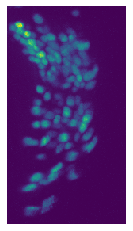

In [5]:
# Section of XY plane where head is found
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

# Extract section
img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]
img = img_as_float(img)

# Display max projection
plt.imshow(np.max(img, 2).T);
plt.axis('off');

### Compute MSE for different numbers of MP iterations

In [6]:
def compute_mse_curve(cov, n_iter):

    n_pixels = img.shape[0] * img.shape[1] * img.shape[2]
    
    err = []
    for n in n_iter:
        pts, weights, debug = imagerep.mp_gaussian(img, cov, n)
        covs = [cov for i in range(n)]
        img_recon = imagerep.reconstruct_image(pts, covs, weights, img.shape)
        err.append(np.sum((img_recon - img) ** 2) / n_pixels)
    
    return err

def compare_mse_curves(covs, n):
    
    n_pixels = img.shape[0] * img.shape[1] * img.shape[2]
    
    results = []
    for cov in covs:
        
        pts, weights, debug = imagerep.mp_gaussian(img, cov, n)
        img_recon = imagerep.reconstruct_image(pts, [cov] * n, weights, img.shape)
        err = np.sum((img_recon - img) ** 2) / n_pixels
        
        results.append({
            'pts': pts,
            'weights': weights,
            'img_recon': img_recon,
            'err': err
        })
    
    return results 

In [7]:
cov_1 = np.diag([4.0, 4.0, 1.0])
cov_2 = np.diag([10.0, 10.0, 2.0])
n_iter = range(100, 1100, 100)

results = []
for n in n_iter:
    
    res = compare_mse_curves([cov_1, cov_2], n)
    results.append(res)
    
    err_1 = res[0]['err']
    err_2 = res[1]['err']
    
    print(f'err_1:{err_1} err_2:{err_2}')

err_1:3.370584213369625e-06 err_2:2.9203361687225277e-06
err_1:3.1302895469759877e-06 err_2:2.6336435049269487e-06
err_1:2.987918541507564e-06 err_2:2.479812357496711e-06
err_1:2.8891076034717725e-06 err_2:2.363400406566247e-06
err_1:2.812122302368375e-06 err_2:2.258929784685972e-06
err_1:2.7496018150017383e-06 err_2:2.1610929523924174e-06
err_1:2.6964426551054484e-06 err_2:2.067937156883336e-06
err_1:2.6492149011771757e-06 err_2:1.9757512070912605e-06
err_1:2.6044322356972137e-06 err_2:1.8904098919699763e-06
err_1:2.5641932024436103e-06 err_2:1.8089633903904313e-06


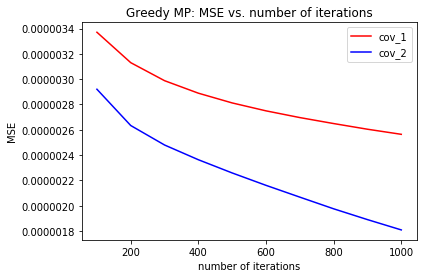

In [8]:
plt.plot(n_iter, [r[0]['err'] for r in results], color='red')
plt.plot(n_iter, [r[1]['err'] for r in results], color='blue')
plt.xlabel('number of iterations')
plt.ylabel('MSE')
plt.title('Greedy MP: MSE vs. number of iterations')
plt.legend(['cov_1', 'cov_2'])
#plt.savefig('mp_err.png')

In [9]:
def plot_mp_iter(k):
    
    n = n_iter[k]
    res = results[k]

    # Errors 
    err_1 = res[0]['err']
    err_2 = res[1]['err']
    
    # Image max projection
    img_mp = np.max(img, 2)

    # Reconstructions
    rc_1 = res[0]['img_recon']
    rc_2 = res[1]['img_recon']
    rc_mp_1 = np.max(rc_1, 2)
    rc_mp_2 = np.max(rc_2, 2)

    # Absolute value of residuals
    rs_1 = np.abs(img - recon_1)
    rs_2 = np.abs(img - recon_2)
    rs_mp_1 = np.max(rs_1, 2)
    rs_mp_2 = np.max(rs_2, 2)
    
    # Compute min and max for plotting
    all_vals = np.array([img_mp, rc_mp_1, rc_mp_2, rs_mp_1, rs_mp_2])
    vmin = np.min(all_vals)
    vmax = np.max(all_vals)

    plt.figure(figsize=(10, 10))
    
    plt.subplot(231)
    plt.imshow(img_mp.T, vmin=vmin, vmax=vmax)
    plt.ylabel(f'cov 1 (err={err_1:.2e})')
    plt.title('original image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(232)
    plt.imshow(rc_mp_1.T, vmin=vmin, vmax=vmax)
    plt.title('reconstruction')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(233)
    plt.imshow(rs_mp_1.T, vmin=vmin, vmax=vmax)
    plt.title('residual')
    plt.xticks([])
    plt.yticks([])
   
    plt.subplot(234)
    plt.imshow(img_mp.T, vmin=vmin, vmax=vmax)
    plt.ylabel(f'cov 2 (err={err_2:.2e})')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(235)
    plt.imshow(rc_mp_2.T, vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(236)
    plt.imshow(rs_mp_2.T, vmin=vmin, vmax=vmax)
    plt.xticks([])
    plt.yticks([])

    plt.suptitle(f'iter={n}');

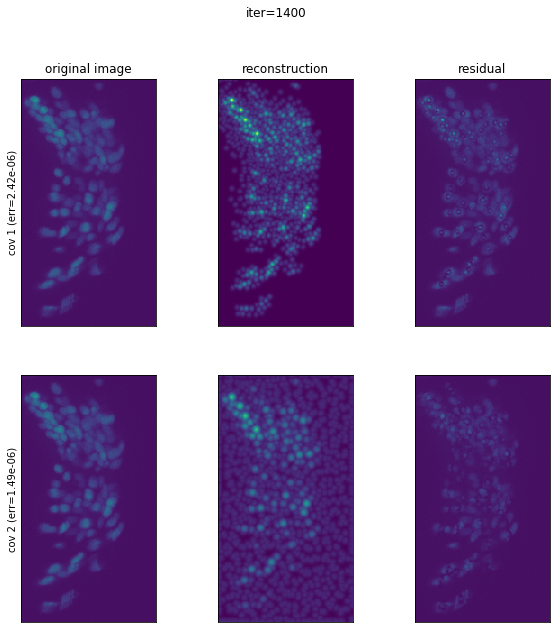

In [103]:
plot_mp_iter(13)